<a href="https://colab.research.google.com/github/davidballezaa/data-science-workshops/blob/main/finance/python4finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

In [3]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
sp500.to_csv("sp500.csv")

In [4]:
sp500 = pd.read_csv("sp500.csv", index_col=0)
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [5]:
sp500.index = pd.to_datetime(sp500.index)

Text(0.5, 1.0, 'Precio de cierre del índice S&P 500')

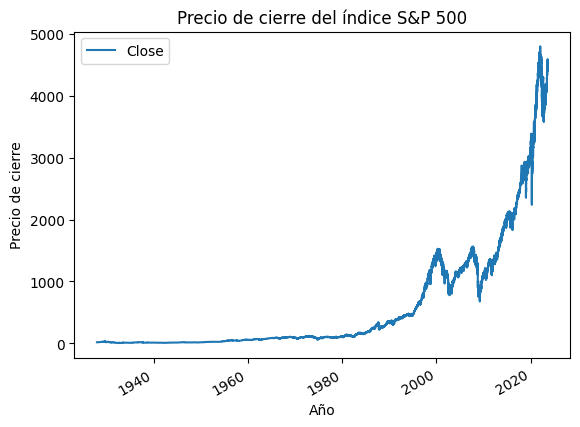

In [6]:
sp500.plot.line(y = "Close", use_index=True)
plt.xlabel("Año")
plt.ylabel("Precio de cierre")
plt.title("Precio de cierre del índice S&P 500")

In [7]:
# delete unnecesary columns
del sp500['Dividends']
del sp500['Stock Splits']

In [8]:
sp500.head()

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0


In [9]:
# this will be target column in RF
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

min_date = datetime(year=1990, month=1, day=1)
min_date = pytz.utc.localize(min_date)
sp500 = sp500[sp500.index > min_date]

# Predicción con rf

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 2)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictor = ["Open", "High", "Low", "Close"]

model.fit(train[predictor], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=2)

In [28]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictor])
preds = pd.Series(preds, index = test.index)
precision = precision_score(test["Target"], preds)

print("Precision:", precision)

Precision: 0.5833333333333334


In [18]:
def predict(train, test, predictor, model):
  model.fit(train[predictor], train["Target"])
  preds = model.predict(test[predictor])
  preds = pd.Series(preds, index = test.index, name="Predictions")

  combined = pd.concat([test["Target"], preds], axis = 1)
  return combined

In [19]:
def backtest(data, model, predictor, start = 2500, step = 250):
  all_predict = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictor, model)
    all_predict.append(predictions)

  return pd.concat(all_predict)

In [20]:
predictions = backtest(sp500, model, predictor)
predictions

,Target,Predictions
Date,,
1999-11-22 00:00:00-05:00,0,0
1999-11-23 00:00:00-05:00,1,0
1999-11-24 00:00:00-05:00,0,0
1999-11-26 00:00:00-05:00,0,0
1999-11-29 00:00:00-05:00,0,0
...,...,...
2023-08-10 00:00:00-04:00,0,1
2023-08-11 00:00:00-04:00,1,1
2023-08-14 00:00:00-04:00,0,1


In [22]:
prediction_count = predictions["Predictions"].value_counts()
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(precision)

0.5275835275835276
